In [130]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

In [3]:
ls

COVID-19.ipynb      coronavirusdataset/


In [4]:
cd coronavirusdataset/

/Users/jinbiao.ji/mygithub/MLTSA_JJi/midterm/coronavirusdataset


In [2]:
from fbprophet import Prophet, diagnostics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot, plot_plotly


In [5]:
time = pd.read_csv('Time.csv')
time.tail()

,date,time,test,negative,confirmed,released,deceased
66,2020-03-26,0,364942,341332,9241,4144,131
67,2020-03-27,0,376961,352410,9332,4528,139
68,2020-03-28,0,387925,361883,9478,4811,144
69,2020-03-29,0,394141,369530,9583,5033,152
70,2020-03-30,0,395194,372002,9661,5228,158


In [6]:
time['date'] = pd.to_datetime(time['date'], format='%Y-%m-%d')

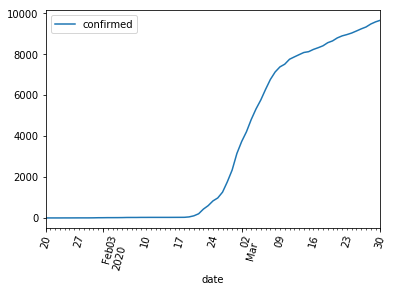

In [7]:
pd.plotting.register_matplotlib_converters()
time.plot(x='date',y='confirmed',rot = 75);

In [8]:
confirmed_data=time.reset_index().rename(columns={'date':'ds','confirmed':'y'})
confirmed_data.head()

,index,ds,time,test,negative,y,released,deceased
66,66,2020-03-26,0,364942,341332,9241,4144,131
67,67,2020-03-27,0,376961,352410,9332,4528,139
68,68,2020-03-28,0,387925,361883,9478,4811,144
69,69,2020-03-29,0,394141,369530,9583,5033,152
70,70,2020-03-30,0,395194,372002,9661,5228,158


In [174]:
confirmed_data.y[50]

7513

### Daily increase

In [178]:
dailyIncrease = [0]
for i in range(confirmed_data.y.size-1):
    dailyIncrease.append(confirmed_data.y[i+1]- confirmed_data.y[i])

In [182]:
confirmed_data['dailyIncrease'] = np.array(dailyIncrease)

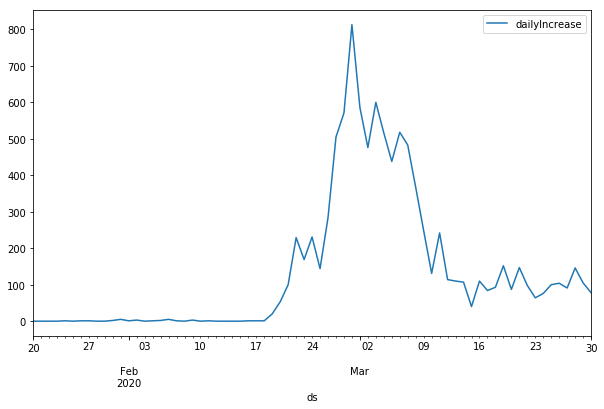

In [185]:
fig,ax=plt.subplots(figsize=(10,6))
confirmed_data.plot(x='ds',y='dailyIncrease',ax=ax)

In [138]:
def mape(y, ytrue): #mean absolute percentage error
    return np.mean(np.abs((ytrue-y)/ytrue))

### 1. Using the default settings to make the prediction.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


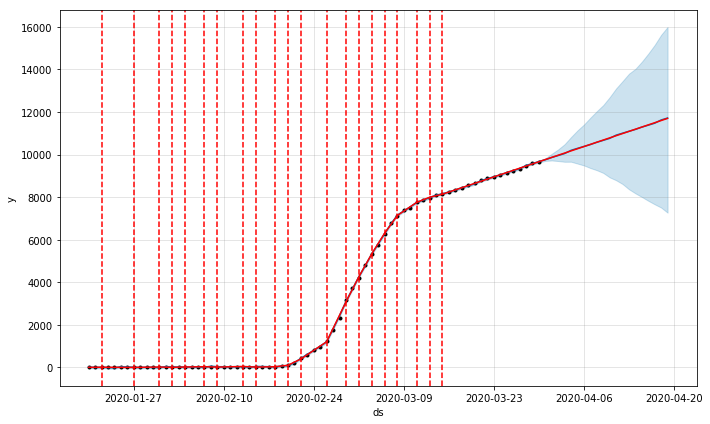

In [199]:
m=Prophet(changepoint_prior_scale=0.5,interval_width=0.95)


m.fit(confirmed_data)

future = m.make_future_dataframe(periods=20)
forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

#a1 = add_changepoints_to_plot(fig1.gca(), m, forecast)

### 2. Using linear growth with only weekly seasonality and define the changepoints.

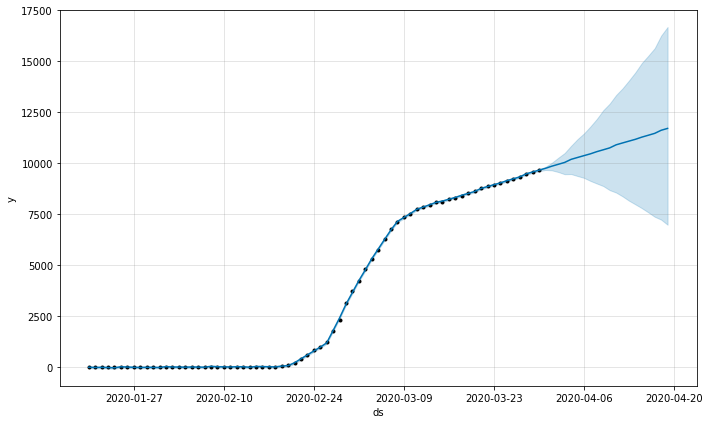

In [242]:
simp = Prophet(growth='linear',interval_width=0.95,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    #changepoints = ['2020-02-21', '2020-02-25','2020-03-08'],
    changepoint_prior_scale=0.5)
#confirmed_data['cap'] = 10000
simp.fit(confirmed_data)
future = simp.make_future_dataframe(periods=20)
forecast = simp.predict(future)
fig3 = simp.plot(forecast)

#a3 = add_changepoints_to_plot(fig3.gca(), simp, forecast)


In [258]:
cvresult_simp = cross_validation(simp, horizon = '10 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


In [259]:
cvresult_simp.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-20,37.966978,31.799602,44.010547,104,2020-02-19
1,2020-02-21,39.584013,34.127625,45.112014,204,2020-02-19
2,2020-02-22,39.904259,34.101110,46.011974,433,2020-02-19
3,2020-02-23,41.974436,35.810764,48.470933,602,2020-02-19
4,2020-02-24,43.024813,37.143666,48.829087,833,2020-02-19


In [141]:
print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simp.yhat, 
                                                           cvresult_simp.y)))

Mean absolute percentage error is  0.2077.


In [260]:
performance_metrics(cvresult_simp)

,horizon,mse,rmse,mae,mape,coverage
0,1 days,3.463323e+05,588.500028,446.611442,0.209804,0.285714
1,2 days,5.813686e+05,762.475284,609.010942,0.260980,0.285714
2,3 days,1.045997e+06,1022.739760,872.386830,0.311926,0.142857
3,4 days,1.663220e+06,1289.658777,1133.470172,0.343057,0.142857
4,5 days,2.558122e+06,1599.413051,1425.876577,0.370583,0.142857
5,6 days,3.458074e+06,1859.589656,1658.114200,0.387682,0.142857
6,7 days,4.476042e+06,2115.665880,1904.084589,0.404474,0.142857
7,8 days,6.213707e+06,2492.730836,2259.097499,0.431261,0.142857
8,9 days,7.773870e+06,2788.166036,2545.738249,0.446805,0.142857
9,10 days,9.756499e+06,3123.539526,2862.971280,0.463303,0.142857


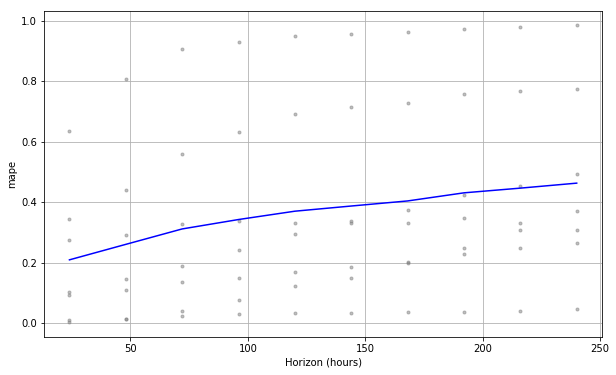

In [261]:
plot_cross_validation_metric(cvresult_simp, metric='mape');

### 3. Logistic growth with only daily seasonality.

Text(47.5, 0.5, 'Confirmed')

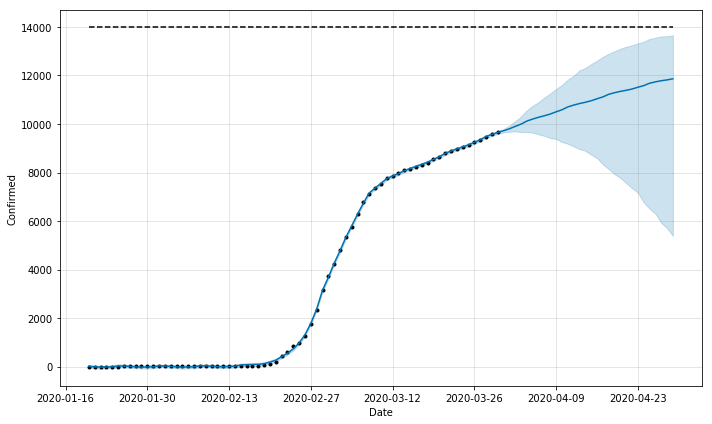

In [249]:
simlog1 = Prophet(growth='logistic',interval_width=0.95,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoint_prior_scale=0.5)
confirmed_data['cap'] = 14000
simlog1.fit(confirmed_data)
future = simlog1.make_future_dataframe(periods=30)
future['cap'] = 14000
forecast = simlog1.predict(future)

fig4, ax = plt.subplots(figsize=(10,6))
simlog1.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')

#a = add_changepoints_to_plot(fig4.gca(), simlog1, forecast)


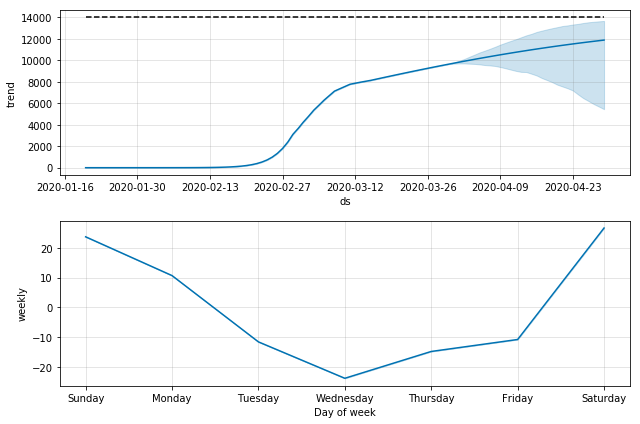

In [250]:
#future = simlog1.make_future_dataframe(periods=30)
#future['cap'] = 11000
#forecast = simlog1.predict(future)
simlog1.plot_components(forecast);

### Plot linear vs logistic models.

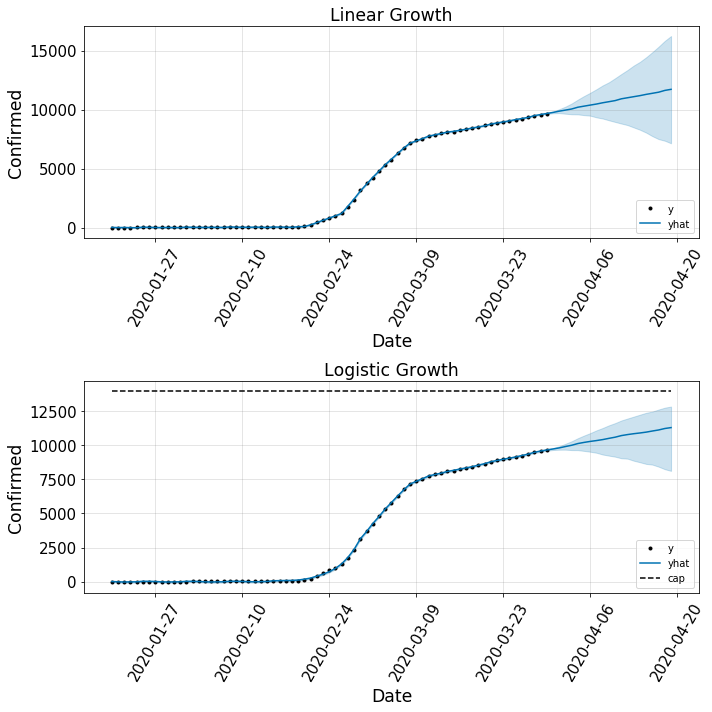

In [251]:
figvs, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))

#linear
future = simp.make_future_dataframe(periods=20)
forecast = simp.predict(future)
simp.plot(forecast,ax = ax1);
ax1.set_title('Linear Growth',fontsize='xx-large' )
ax1.set_xlabel('Date',fontsize='xx-large')
ax1.set_ylabel('Confirmed',fontsize='xx-large')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60)
ax1.legend(loc=4)

#logistic
future = simlog1.make_future_dataframe(periods=20)
future['cap'] = 14000
forecast = simlog1.predict(future)
simlog1.plot(forecast,ax=ax2)
ax2.set_xlabel('Date',fontsize='xx-large')
ax2.set_ylabel('Confirmed',fontsize='xx-large')
ax2.set_title('Logistic Growth',fontsize='xx-large')

ax2.tick_params(axis='both', which='major', labelsize=15)

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60)

ax2.legend(loc=4)

figvs.tight_layout()

In [254]:
cvresult_simlog1 = cross_validation(simp, horizon = '10 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


In [255]:
print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlog1.yhat, 
                                                           cvresult_simlog1.y)))

Mean absolute percentage error is  0.3630.


In [256]:
performance_metrics(cvresult_simlog1)

,horizon,mse,rmse,mae,mape,coverage
0,1 days,3.463323e+05,588.500028,446.611442,0.209804,0.285714
1,2 days,5.813686e+05,762.475284,609.010942,0.260980,0.285714
2,3 days,1.045997e+06,1022.739760,872.386830,0.311926,0.142857
3,4 days,1.663220e+06,1289.658777,1133.470172,0.343057,0.142857
4,5 days,2.558122e+06,1599.413051,1425.876577,0.370583,0.142857
5,6 days,3.458074e+06,1859.589656,1658.114200,0.387682,0.142857
6,7 days,4.476042e+06,2115.665880,1904.084589,0.404474,0.142857
7,8 days,6.213707e+06,2492.730836,2259.097499,0.431261,0.142857
8,9 days,7.773870e+06,2788.166036,2545.738249,0.446805,0.142857
9,10 days,9.756499e+06,3123.539526,2862.971280,0.463303,0.142857


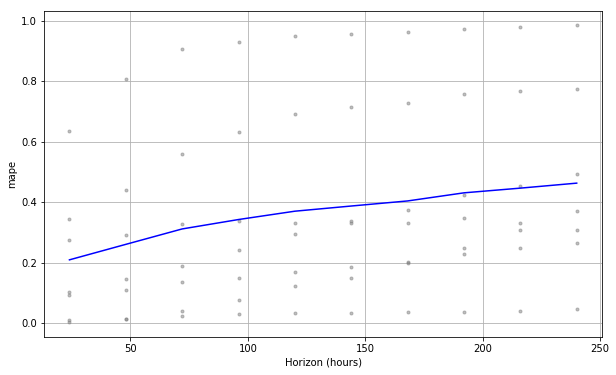

In [257]:
plot_cross_validation_metric(cvresult_simlog1, metric='mape');

**Figure.** Dots show the absolute percent error for each prediction in `confirmed_data`. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors are around 10% for 1 day into the future and then increas up to around 27% for predictions that are 10 days out.

#### Define changepoints

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



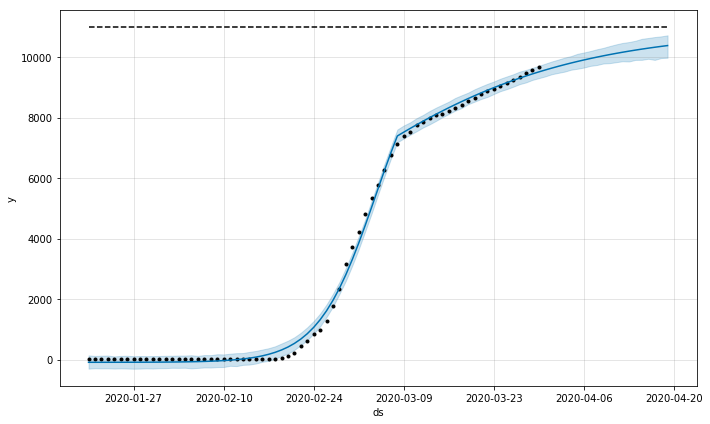

In [121]:
#define changepoints
simlog2 = Prophet(growth='logistic',
    yearly_seasonality=False,
    weekly_seasonality = False,
    daily_seasonality = True,
    seasonality_mode = 'additive',
    changepoints = ['2020-02-21', '2020-02-25','2020-03-08'],
    changepoint_prior_scale=0.5)
confirmed_data['cap'] = 11000
simlog2.fit(confirmed_data)
future = simlog2.make_future_dataframe(periods=20)
future['cap'] = 11000
forecast = simlog2.predict(future)
fig5 = simlog2.plot(forecast)

In [142]:
performance_metrics(cvresult_simlog2)

,horizon,mse,rmse,mae,mape,coverage
0,1 days,2.005167e+05,447.790865,345.704342,0.396255,0.285714
1,2 days,4.062043e+05,637.341565,509.591484,0.231309,0.285714
2,3 days,7.028082e+05,838.336589,664.012340,0.190300,0.285714
3,4 days,1.193016e+06,1092.252599,872.434556,0.244945,0.285714
4,5 days,1.839014e+06,1356.102339,1101.149859,0.278177,0.285714
5,6 days,2.550177e+06,1596.927347,1285.552255,0.302766,0.285714
6,7 days,3.448705e+06,1857.068878,1491.147811,0.330851,0.285714
7,8 days,4.210825e+06,2052.029370,1673.442967,0.343557,0.285714
8,9 days,4.902112e+06,2214.071445,1824.000545,0.348355,0.285714
9,10 days,5.788328e+06,2405.894508,2003.393605,0.353576,0.285714


In [143]:
cvresult_simlog2 = cross_validation(simlog2, horizon = '10 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00


In [144]:
print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlog2.yhat, 
                                                           cvresult_simlog2.y)))

Mean absolute percentage error is  0.3020.


### MCMC optimization

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



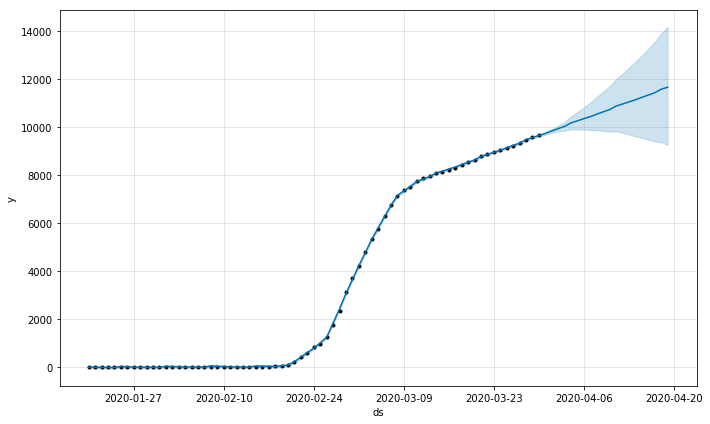

In [21]:
regmcmc = Prophet(mcmc_samples=5000)

#regmcmc.add_country_holidays(country_name='KR')

#confirmed_data['cap'] = 11000
regmcmc.fit(confirmed_data)
future = regmcmc.make_future_dataframe(periods=20)
#future['cap'] = 11000
forecast = regmcmc.predict(future)
fig7 = regmcmc.plot(forecast)

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



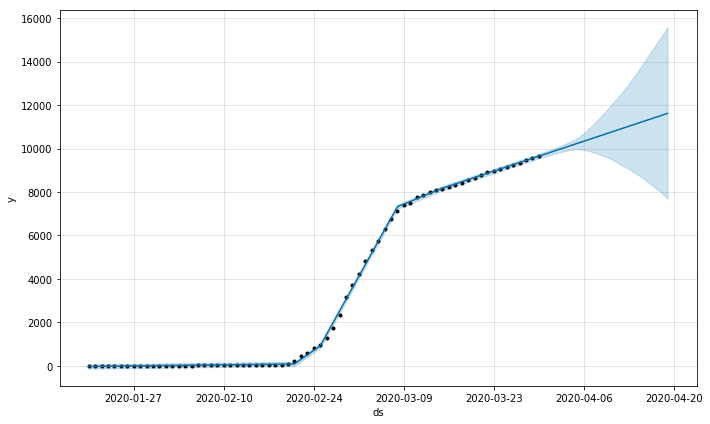

In [24]:
regmcmc2 = Prophet( yearly_seasonality=False,
    weekly_seasonality = False,
    daily_seasonality = True,
    seasonality_mode = 'additive',
    changepoints = ['2020-02-21', '2020-02-25','2020-03-08','2020-03-15'],
    changepoint_prior_scale=0.5,
                   mcmc_samples=5000)

#regmcmc.add_country_holidays(country_name='KR')

#confirmed_data['cap'] = 11000
regmcmc2.fit(confirmed_data)
future = regmcmc2.make_future_dataframe(periods=20)
#future['cap'] = 11000
forecast = regmcmc2.predict(future)
fig8 = regmcmc2.plot(forecast)

In [53]:
cvresult_regmcmc = diagnostics.cross_validation(regmcmc, horizon = '10 days')


INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-package

In [127]:
cvresult_regmcmc.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
65,2020-03-26,11599.675486,10608.485318,12550.321210,9241,2020-03-20
66,2020-03-27,11907.558972,10915.013556,12911.091570,9332,2020-03-20
67,2020-03-28,12395.158733,11374.112722,13411.752065,9478,2020-03-20
68,2020-03-29,12694.160522,11661.985074,13715.646528,9583,2020-03-20
69,2020-03-30,12988.444509,11913.713371,14041.460911,9661,2020-03-20


In [59]:
cvresult_regmcmc.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-20,38.395880,31.768425,45.026233,104,2020-02-19
1,2020-02-21,40.176921,33.553059,46.633744,204,2020-02-19
2,2020-02-22,40.427537,33.774595,47.107260,433,2020-02-19
3,2020-02-23,42.464411,35.672569,49.366382,602,2020-02-19
4,2020-02-24,43.891219,36.921213,50.631146,833,2020-02-19


In [128]:
performance_metrics(regmcmc)

AttributeError: 'Prophet' object has no attribute 'copy'

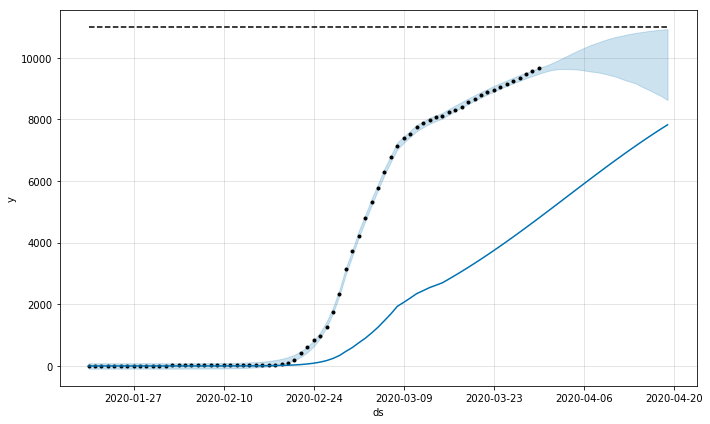

In [195]:
regmcmc3 = Prophet(growth='logistic',interval_width=0.95,
    yearly_seasonality=False,
    weekly_seasonality = False,
    daily_seasonality = True,
    changepoint_prior_scale=0.5,
    mcmc_samples=5000)

#regmcmc.add_country_holidays(country_name='KR')

confirmed_data['cap'] = 11000
regmcmc3.fit(confirmed_data)
future = regmcmc3.make_future_dataframe(periods=20)
future['cap'] = 11000
forecast = regmcmc3.predict(future)
fig9 = regmcmc3.plot(forecast)

In [196]:
cvresult_regmcmc3 = diagnostics.cross_validation(regmcmc3, horizon = '10 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


KeyboardInterrupt: 

### Logistics Growth - Define funcion with the coefficients to estimate the 'cap'.

In [74]:
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [77]:
from scipy.optimize import curve_fit

In [102]:
# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)

# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])

# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(time.index.values)+1
y = np.array(time['confirmed'])

(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)

In [104]:
# The time step at which the growth is fastest
t_fastest = np.log(a) / b
i_fastest = func_logistic(t_fastest, a, b, c)

In [115]:
res_df = time['date'].copy()
res_df['fastest_grow_day'] = t_fastest
res_df['fastest_grow_value'] = i_fastest
res_df['growth_stabilized'] = t_fastest <= x[-1]
res_df['timestep'] = x
res_df['res_func_logistic'] = func_logistic(x, a, b, c)


if t_fastest <= x[-1]:
    print('Growth stabilized: South Korea.','| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
    res_df['cap'] = func_logistic(x[-1] + 10, a, b, c)
else:
    print('Growth increasing: South Korea,',  '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
    res_df['cap'] = func_logistic(i_fastest + 10, a, b, c)

Growth stabilized: South Korea. | Fastest grow day: 43.89792405460557 | Infections: 4477.29619478658


8954.002674075082

### Step 2

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



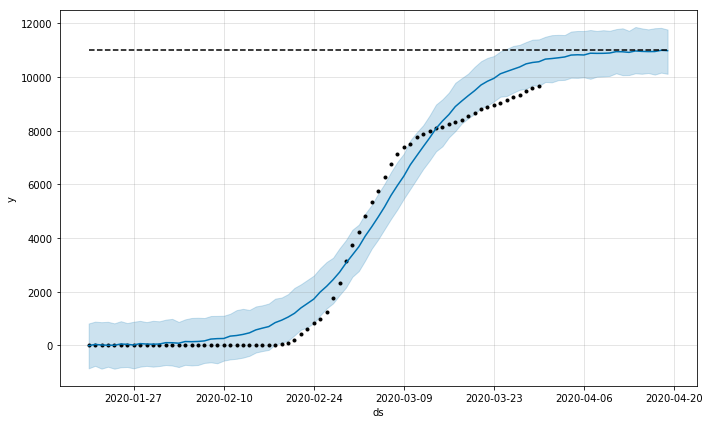

In [120]:
m = Prophet(growth='logistic')
m.fit(confirmed_data)
future = m.make_future_dataframe(periods=20)
future['cap'] = 11000
forecast = m.predict(future)
fig5 = simlog2.plot(forecast)